In [2]:
import re 
import nltk
import joblib
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.utils import resample
from spellchecker import SpellChecker
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier 

In [3]:
df = pd.read_csv('email_spam_dataset.csv', encoding='ISO-8859-1')

In [4]:
df['Email'].head()


0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: Email, dtype: object

In [5]:
df['Email'].isnull().sum()

0

In [6]:
df['Email'].duplicated().sum()

403

In [7]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [8]:
# Seprate Class
df_ham = df[df['Category'] == 'ham']
df_spam = df[df['Category'] == 'spam']

# Upsample spam
df_spam_upsampled = resample(df_spam,
                             replace=True,
                             n_samples=len(df_ham),
                             random_state=42)

# Combine
df1 = pd.concat([df_ham, df_spam_upsampled])

# Shuffle
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
df1['Category'].value_counts()

Category
ham     4825
spam    4825
Name: count, dtype: int64

In [10]:
df1.head()

,Category,Email,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,Mm yes dear look how i am hugging you both. :-P,NaN,NaN,NaN
1,ham,But pls dont play in others life.,NaN,NaN,NaN
2,ham,i can call in &lt;#&gt; min if thats ok,NaN,NaN,NaN
3,ham,HMM yeah if your not too grooved out! And im l...,NaN,NaN,NaN
4,spam,"Latest News! Police station toilet stolen, cop...",NaN,NaN,NaN


In [11]:
df_balanced = df1[['Category', 'Email']]

In [12]:
df_balanced.head()

,Category,Email
0,ham,Mm yes dear look how i am hugging you both. :-P
1,ham,But pls dont play in others life.
2,ham,i can call in &lt;#&gt; min if thats ok
3,ham,HMM yeah if your not too grooved out! And im l...
4,spam,"Latest News! Police station toilet stolen, cop..."


<Axes: xlabel='Category'>

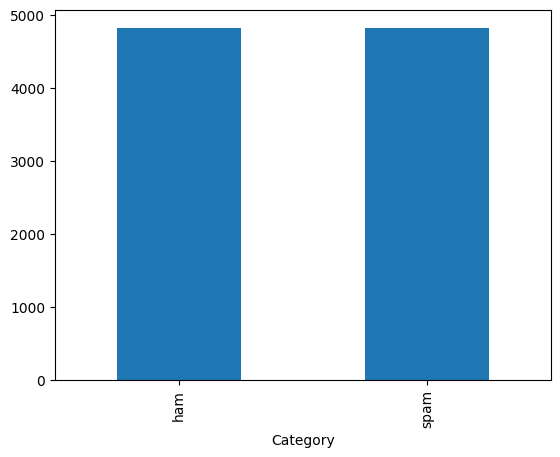

In [13]:
df_balanced['Category'].value_counts().plot(kind='bar')

In [14]:
df_balanced['length'] = df_balanced['Email'].apply(len)

C:\Users\mohammad ehtesham\AppData\Local\Temp\ipykernel_27448\4009203362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_balanced['length'] = df_balanced['Email'].apply(len)


In [15]:
df_balanced.head()

,Category,Email,length
0,ham,Mm yes dear look how i am hugging you both. :-P,47
1,ham,But pls dont play in others life.,33
2,ham,i can call in &lt;#&gt; min if thats ok,41
3,ham,HMM yeah if your not too grooved out! And im l...,83
4,spam,"Latest News! Police station toilet stolen, cop...",70


In [17]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_balanced['Email'] = df_balanced['Email'].apply(clean_text)


C:\Users\mohammad ehtesham\AppData\Local\Temp\ipykernel_27448\3067596104.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_balanced['Email'] = df_balanced['Email'].apply(clean_text)


In [18]:
df_balanced

,Category,Email,length
0,ham,mm yes dear look how i am hugging you both p,47
1,ham,but pls dont play in others life,33
2,ham,i can call in lt gt min if thats ok,41
3,ham,hmm yeah if your not too grooved out and im lo...,83
4,spam,latest news police station toilet stolen cops ...,70
...,...,...,...
9645,spam,sms services for your inclusive text credits p...,158
9646,spam,loan for any purpose å å homeowners tenants we...,164
9647,spam,if you don t your prize will go to another cus...,144
9648,ham,ya told she was asking wats matter,37


In [19]:
X = df_balanced['Email']
y = df_balanced['Category']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
tfidf = TfidfVectorizer(max_features = 5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [22]:
models = {
    "Logistic Regression" : LogisticRegression(),
    "Decision Tree" : DecisionTreeClassifier(),
    "Random Forest" : RandomForestClassifier(),
    "SVM" : SVC(),
    "Naive Bayes" : MultinomialNB()
}

In [23]:
params = {

    "Logistic Regression": {
        "C": [0.1, 1, 10],
        "max_iter": [100, 200]
    },

    "Naive Bayes": {
        "alpha": [0.1, 0.5, 1.0]
    },

    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"]
    },

    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [5, 10, 20]
    },

    "Random Forest": {
        "n_estimators": [50, 100],
        "max_depth": [10, 20],
    }
}

In [24]:
scores = []

for name, model in models.items():
    

    clf = GridSearchCV(
        model, 
        params[name], 
        cv=5,
        n_jobs=-1,
        return_train_score=False
    )

    clf.fit(X_train_tfidf, y_train)

    scores.append({
        "model": name,
        "best_score": clf.best_score_,
        "best_params": clf.best_params_
    })

In [25]:
results = pd.DataFrame(scores)
print(results)

                 model  best_score                                best_params
0  Logistic Regression    0.997150                 {'C': 10, 'max_iter': 100}
1        Decision Tree    0.976425  {'criterion': 'entropy', 'max_depth': 20}
2        Random Forest    0.966580     {'max_depth': 20, 'n_estimators': 100}
3                  SVM    0.998964                 {'C': 10, 'kernel': 'rbf'}
4          Naive Bayes    0.988472                             {'alpha': 0.1}


In [27]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [28]:
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9917098445595854


In [29]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

print("Precision:", precision_score(y_test, y_pred, pos_label="spam"))
print("Recall:", recall_score(y_test, y_pred, pos_label="spam"))
print("F1 Score:", f1_score(y_test, y_pred, pos_label="spam"))

Precision: 0.9916230366492147
Recall: 0.9916230366492147
F1 Score: 0.9916230366492147


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       975
        spam       0.99      0.99      0.99       955

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



<Axes: >

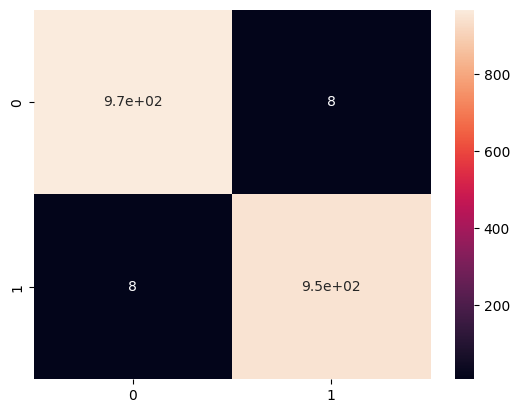

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)


In [34]:
# Save model
joblib.dump(model, "spam_classifier_model.pkl")

# Save TF-IDF vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']